[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana10/2_RL_Hedging.ipynb)


# Reinforcement Learning (Aprendizaje por refuerzo) - Hedging en opciones

Se realizarán las simulaciones de 3 millones de trayectorias como posibles movimientos de un activo que serán calculados utilizando la fórmula de Black-Scholes (a veces conocida como Black-Scholes-Merton) y con esto se entrenará un agente de aprendizaje por refuerzo.

# Dependencias

In [ ]:
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm
n = norm.pdf
N = norm.cdf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ejemplo del decorador
total = 0
for i in tqdm(range(1000000)):
  total += 1

  0%|          | 0/1000000 [00:00<?, ?it/s]

# Funciones Auxiliares

In [ ]:
# Para la simulación de las trayectorias de la acción utilizando Black-Scholes
def brownian_sim(num_path, num_period, mu, std, init_p, dt):
    z = np.random.normal(size=(num_path, num_period))

    a_price = np.zeros((num_path, num_period))
    a_price[:, 0] = init_p

    for t in range(num_period - 1):
        a_price[:, t+1] = a_price[:, t] * np.exp(
            (mu - (std ** 2) / 2) * dt + std * np.sqrt(dt) * z[:, t]
        )
    return a_price

# Función para la valuación de Opciones (Call) y cálculo de Delta usando Black-Scholes
# T es el tiempo de madurez anualizado
def bs_parameter(v, T, S, K, r, q):
    np.seterr(divide='ignore', invalid='ignore')
    d1 = (np.log(S / K) + (r - q + v * v / 2) * T) / (v * np.sqrt(T))
    d2 = d1 - v * np.sqrt(T)
    bs_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    bs_delta = np.exp(-q * T) * norm.cdf(d1)
    return bs_price, bs_delta


In [ ]:
# Define el numero de trayectorias generadas para entrenamiento y prueba
TRAINING_SAMPLE = 3000000 # 3,000K 
TESTING_SAMPLE = 100000 # 100K

# Características subyacentes del proceso para las acciones
# Retorno anual de la acción
MU = 0
# Volatilidad anual
VOL = 0.2
# Valor inicial del activo
S = 100
# Retorno anual ofrecido por un activo con cero riesgo (Risk Free Rate)
R = 0
# Dividendos anuales
DIVIDEND = 0
# Días al año para compra-venta (trading)
T = 250

# Características de la Opción Call
# Precio acordado en la Opción (Strike)
K = 100
# Tiempo de madurez de la opción
M = 10
# Número de posiciones posibles[de 0 a 10] (estado)
N_POSITION = 11
# Número de acciones posibles [de -5 a 5]
N_ACTION = 11

# Costo por 'Trading', medido porcentualmente
TRADING_COST = 0

# Definición de variables para aprendizaje por refuerzo
# Constante para la función de recompensa
constant = 1
# epsilon mínimo
MIN_e = 0.05
# epsilon inicial
e = 1
# Decaimiento temporal
DECAY = 0.999999

# Parámetros para actualizar Q
ALPHA = 0.01

# Escoger el número de estados para el precio de la acción. Los precios se redondean al entero mas cercano.
# Precios mayores o iguales a 107 son tomados como el mismo estado
# Precios menores o iguales a 93 son tomados como el mismo estado
STOCK_PRICE_STATE = 15

In [ ]:
# Avance de tiempo por día
dt = 1/T

# Serie para el tiempo de madurez de la opción
ttm = np.arange(M,-1, -1)

In [ ]:
# Inicializa Q con valores cero para los pares estado-decisión (acción)
q = np.zeros((M+1,STOCK_PRICE_STATE,N_POSITION,N_ACTION))

In [ ]:
# Las dimensions representan: Madurez, Precio de activo, Estado de Hedge, Acción a tomar
q.shape

(11, 15, 11, 11)

In [ ]:
# Acciones a tomar cuando
# El tiempo de madurez llegó a 10, el precio del activo es 100 (la posición del 7) y posee 8 shares de activos
q[10,7,8]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Fase de entrenamiento

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
# Simulación de trayectorias y cálculo de parámetros BS para fase de entrenamiento
price_table = brownian_sim(TRAINING_SAMPLE,M+1, MU, VOL, S, dt)
call_price_table, delta_table = bs_parameter(VOL, ttm / T, price_table, K,R, DIVIDEND)
print("Simulación de trayectorias de activos y calculo de parámetros BS completados")

Simulación de trayectorias de activos y calculo de parámetros BS completados


In [ ]:
j=10

In [ ]:
price_table[1]

array([100.        ,  99.31939639, 100.3169619 ,  99.10410415,
       100.12760193, 101.40834547, 101.24927304, 101.63260327,
        99.71951471,  97.65584041,  96.9904121 ])

In [ ]:
call_price_table[j]

array([1.59566274, 0.89241975, 0.89080238, 0.92003976, 1.03382042,
       0.20236345, 0.20712045, 0.31267587, 0.59560608, 0.09875383,
       1.09884313])

In [ ]:
delta_table[j]

array([0.50797831, 0.35850582, 0.37240044, 0.39787304, 0.45182728,
       0.14528265, 0.161125  , 0.24661088, 0.44833471, 0.152869  ,
       1.        ])

In [ ]:
# Redondeo de los precios de activo y convertirlos a los 15 diferentes estados
# [<=93,94,95,96, ... 103,104,105,106, >= 107] - > [0,1,2,3,4,5,....12,13,14,15]
price_state_table = np.round(price_table).astype(int)
price_state_table = np.where(price_state_table < 93, 93, price_state_table)
price_state_table = np.where(price_state_table > 107, 107, price_state_table)
price_state_table = price_state_table - 93

In [ ]:
price_state_table[1]

array([7, 6, 7, 6, 7, 8, 8, 9, 7, 5, 4])

In [ ]:
print("Entrenamiento en proceso:")

for i in tqdm(range(len(price_table))):

    asset_price = price_table[i]
    price_state = price_state_table[i]
    bscall = call_price_table[i]
    position = 0
    position_list = np.empty(0, dtype=int)
    reward_list = np.empty(0, dtype=int)
    action_list = np.empty(0, dtype=int)
    total_reward = np.empty(0, dtype=int)
    
    for t in range(M):
        if np.random.rand() <= e:
            # Aplicamos EXPLORACIÓN
            # Note que el rango de las acciones está entre vender 5 shares y comprar 5 shares
            # Por eso aquí se restan 5 a la acción tomada
            action = random.randrange(0,N_ACTION) - 5
        else:
            # EXPLOTACIÓN
            # Asumimos que en el tiempo 0 el agente tiene 0 shares
            if t == 0: 
                lookup_position = 0
            
            else:
                lookup_position = position_list[t-1]
            # Si se activa 'explotación', encuentra el mínimo valor no-cero en Q
            # Se usa un 'try' porque el agente puede llegar a un estado no visitado antes y ahi todos los valores de Q son ceros
            # Si el agente llega a un estado en que nunca ha estado antes, se toma una acción al azar
            try:
                action = np.where(q[t][price_state[t]][lookup_position]==np.min(q[t][price_state[t]][lookup_position][np.nonzero(q[t][price_state[t]][lookup_position])]))[0][0] - 5 
            except:
                action = random.randrange(0,N_ACTION) - 5
        
        # Obligando al agente a que solo tenga entre 0 y 10 shares
        if position + action >10:
            action = 10 - position
            new_position = 10
        elif position + action <0:
            action = -position
            new_position = 0             
        else:
            new_position = action + position
        
        # Condicional para calcular el costo por transacción (cuando no es cero) Nota: Cuando se quiere encontrar delta para delta hedging, el costo por transacción es 0
        # Si t es un día antes de la fecha de madurez, se cobra un extra por venderlos al final del periodo
        if t == M-1:
            transaction_cost = (asset_price[t]*abs(new_position - position)*TRADING_COST + new_position*asset_price[t+1]*TRADING_COST)
        else:
            transaction_cost = (asset_price[t]*abs(new_position - position)*TRADING_COST)
        
        # La Recompensa se calcula como
        # PNL es una formulación en la que el hedge se calcula en cada etapa
        # expected hedging cost + constant * variance of total pnl from hedging.
        
        # Buscando delta, la recompensa es minimizando la varianza de P&L total del caso de hedging
        # La constante se toma 1 para el caso de buscar delta.
        reward = transaction_cost + constant * (transaction_cost-(asset_price[t+1] - asset_price[t])*new_position+10*(bscall[t+1] - bscall[t]))**2
        
        position_list= np.append(position_list,new_position)
        position = new_position
        action_list = np.append(action_list,action)
        reward_list = np.append(reward_list,reward)
        

    position_list = np.append(position_list,0)
    action_list = np.append(action_list,0)
    total_reward  = np.append(total_reward,sum(reward_list))
    
    # Convierte la lista de acciones de -5 a 5 en la de 0 a 10, la tabla empieza con el índice 0
    # Es decir: índice 0 en la tabla significa acción = -5 e índice 10 en tabla significa acción = 5
    action_list = action_list + 5
    
    # Actualizar Q
    for t in range(M):
        if t == 0: 
            lookup_position = 0
        else:
            lookup_position = position_list[t-1]
        qnew = reward_list[t] + q[t+1][price_state[t+1]][position_list[t]][action_list[t+1]]
        q[t][price_state[t]][lookup_position][action_list[t]] = q[t][price_state[t]][lookup_position][action_list[t]] + ALPHA * (qnew - q[t][price_state[t]][lookup_position][action_list[t]]) 
    
    # Decae con el tiempo (epsilon) para que el agente se vuela mas propenso a usar EXPLOTACIÓN
    if e > MIN_e:
        e = e * DECAY

# Save Q at the end after training 
np.save('/content/drive/MyDrive/Cruso-ApsFinancieras/semana10/Q_RL_Hedging',q)     

# Fase de pruebas

Aquí el agente ya no está interesado en aprender, solo en llevar a cabo la mejor decisión posible


In [ ]:
# Cargar Q de entrenamiento
q = np.load('/content/drive/MyDrive/Cruso-ApsFinancieras/semana10/Q_RL_Hedging.npy')  

In [ ]:
q[6,7,8]

array([37.8014903 , 36.99398929, 23.51592473, 35.56369662, 34.09858222,
       53.7151978 , 58.79775478, 66.37136488,  0.        ,  0.        ,
        0.        ])

In [ ]:
# Simulación de trayectorias y cálculo de parámetros BS para fase de entrenamiento de pruebas
price_table = brownian_sim(TESTING_SAMPLE,M+1, MU, VOL, S, dt)
call_price_table, delta_table = bs_parameter(VOL, ttm / T, price_table, K,R, DIVIDEND)

In [ ]:
# Redondear delta al primer decimal mas cercano
rounded_delta = np.round(delta_table*100/10,0).astype(int)
print("Simulación de trayectorias de activos y calculo de parámetros BS completados")

# Redondeo de los precios de activo y convertirlos a los 15 diferentes estados
# [<=93,94,95,96, ... 103,104,105,106, >= 107] - > [0,1,2,3,4,5,....12,13,14,15]
price_state_table = np.round(price_table).astype(int)
price_state_table = np.where(price_state_table < 93, 93, price_state_table)
price_state_table = np.where(price_state_table > 107, 107, price_state_table)
price_state_table = price_state_table - 93

Simulación de trayectorias de activos y calculo de parámetros BS completados


In [ ]:
rounded_delta

array([[ 5,  6,  7, ...,  7,  4,  0],
       [ 5,  4,  3, ...,  4,  4, 10],
       [ 5,  5,  5, ...,  8, 10, 10],
       ...,
       [ 5,  5,  6, ..., 10, 10, 10],
       [ 5,  5,  7, ...,  0,  0,  0],
       [ 5,  4,  5, ...,  9, 10, 10]])

In [ ]:
delta_table

array([[0.50797831, 0.5605575 , 0.67803959, ..., 0.70833436, 0.35086437,
        0.        ],
       [0.50797831, 0.38952631, 0.34438916, ..., 0.41146989, 0.40442099,
        1.        ],
       [0.50797831, 0.45380049, 0.54416738, ..., 0.75617493, 0.95226379,
        1.        ],
       ...,
       [0.50797831, 0.49601529, 0.63156664, ..., 0.99999921, 1.        ,
        1.        ],
       [0.50797831, 0.540152  , 0.69279329, ..., 0.0000139 , 0.00000002,
        0.        ],
       [0.50797831, 0.44142752, 0.46828715, ..., 0.86903246, 0.99762047,
        1.        ]])

In [ ]:
total_rl_reward = np.empty(0, dtype=int)
total_dh_reward = np.empty(0, dtype=int)
all_shares_pnl = np.empty(shape=(TESTING_SAMPLE, len(ttm)-1))
all_call_option_pnl = np.empty(shape=(TESTING_SAMPLE, len(ttm)-1))
abs_deviation = list()

print("Test is in progress:")
for i in tqdm(range(len(price_table))):
    
    rl_position = 0
    dh_position = 0
    asset_price = price_table[i]
    price_state = price_state_table[i]
    bscall = call_price_table[i]
    bsdelta = rounded_delta[i]
    position_list = np.empty(0, dtype=int)
    rl_reward_list = np.empty(0, dtype=int)
    dh_reward_list = np.empty(0, dtype=int)
    action_list = np.empty(0, dtype=int)
    shares_pnl = np.empty(0, dtype=int)
    call_option_pnl = np.empty(0, dtype=int)
    
    for t in range(M):
        
        # Posición a mantener si el agente aplicará Delta Hedging
        new_dh_position = bsdelta[t]
        
        # Asumimos que en el tiempo 0 el agente tiene 0 shares
        if t == 0: 
            lookup_position = 0
        else:
            lookup_position = position_list[t-1]
        
        # Escoge acción encontrando el mínimo valor no cero en la tabla Q
        # Usar el try porque puede que el agente haya llegado a una posición no antes vista.
        # Si eso sucede, el agente no intercambia shares de ninguna manera        
        try:
            rl_action = np.where(q[t][price_state[t]][lookup_position]==np.min(q[t][price_state[t]][lookup_position][np.nonzero(q[t][price_state[t]][lookup_position])]))[0][0] - 5 
        except:
            rl_action = 0
        
        # Obligamos al agente a mantener shares entre 0 y 10
        if rl_position + rl_action >10:
            rl_action = 10 - rl_position
            new_rl_position = 10
        elif rl_position + rl_action <0:
            rl_action = -rl_position
            new_rl_position = 0

        else:
            new_rl_position = rl_action + rl_position 
        
        # Calculamos el P&L periodo a periodo para ambos casos: Delta Hedge y Renforcement Learning Hedging
        if t == M-1:
            rl_transaction_cost = (asset_price[t]*abs(new_rl_position - rl_position)*TRADING_COST + new_rl_position*asset_price[t+1]*TRADING_COST)
            dh_transaction_cost = (asset_price[t]*abs(new_dh_position - dh_position)*TRADING_COST + new_dh_position*asset_price[t+1]*TRADING_COST)
        else:
            rl_transaction_cost = (asset_price[t]*abs(new_rl_position - rl_position)*TRADING_COST)
            dh_transaction_cost = (asset_price[t]*abs(new_dh_position - dh_position)*TRADING_COST)
        
        
        call_option_pnl = np.append(call_option_pnl,10*(bscall[t+1] - bscall[t]))
        shares_pnl = np.append(shares_pnl, (asset_price[t+1] - asset_price[t])*new_rl_position)
        rl_reward = rl_transaction_cost - (asset_price[t+1] - asset_price[t])*new_rl_position+10*(bscall[t+1] - bscall[t])
        dh_reward = dh_transaction_cost - (asset_price[t+1] - asset_price[t])*new_dh_position+10*(bscall[t+1] - bscall[t])
    
        
        position_list= np.append(position_list,new_rl_position)
        action_list = np.append(action_list,rl_action)
        rl_position = new_rl_position
        dh_position = new_dh_position
        rl_reward_list = np.append(rl_reward_list,rl_reward)
        dh_reward_list = np.append(dh_reward_list,dh_reward)
    
    abs_deviation = np.append(abs_deviation,sum(abs(bsdelta[:-1]-position_list))/10)    
    position_list = np.append(position_list,0)
    action_list = np.append(action_list,0) 
    total_rl_reward = np.append(total_rl_reward,sum(rl_reward_list))
    total_dh_reward = np.append(total_dh_reward,sum(dh_reward_list))
    all_shares_pnl[i,:] = shares_pnl
    all_call_option_pnl[i,:]  = call_option_pnl
    
print('\n Estadísticas de Reinforcement Learning Hedging:')
print(' RL E(C):', np.average(total_rl_reward))
print(' RL var(C):', np.var(total_rl_reward))
print(' RL std(C):', np.std(total_rl_reward))

print('\n Estadísticas de Delta Hedging:')
print(' Delta E(C):', np.average(total_dh_reward))
print(' Delta var(C):', np.var(total_dh_reward))
print(' Delta std(C):', np.std(total_dh_reward))

print('\n Diferencia en la posición:')
print(' Diferencia absoluta promedio entre la position de DH y RLH:', np.average(abs_deviation))


Test is in progress:


  0%|          | 0/100000 [00:00<?, ?it/s]


 Estadísticas de Reinforcement Learning Hedging:
 RL E(C): -0.014520023836898563
 RL var(C): 22.604537393787556
 RL std(C): 4.754422929629584

 Estadísticas de Delta Hedging:
 Delta E(C): -0.0066727009227978695
 Delta var(C): 19.066853180118585
 Delta std(C): 4.366560795422249

 Diferencia en la posición:
 Diferencia absoluta promedio entre la position de DH y RLH: 0.318126


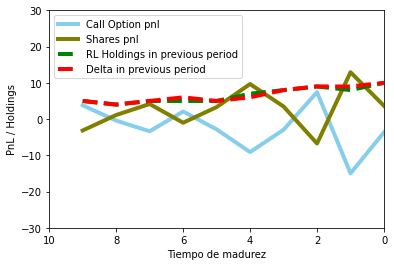

In [ ]:
# Visualización de P&L para la última trayectoria en datos de prueba (test)

df=pd.DataFrame({'Time to Maturity': ttm[1:], 'Call Option pnl': -all_call_option_pnl[-1,:], 'Shares pnl': all_shares_pnl[-1,:], 'RL Holdings': position_list[:-1], 'Delta': bsdelta[:-1]})
 
# Plot de multiples lineas
plt.plot( 'Time to Maturity', 'Call Option pnl', data=df, marker='', color='skyblue', linewidth=4)
plt.plot( 'Time to Maturity', 'Shares pnl', data=df, marker='', color='olive', linewidth=4)
plt.plot( 'Time to Maturity', 'RL Holdings', data=df, marker='', color='green', linewidth=4, linestyle='dashed')
plt.plot( 'Time to Maturity', 'Delta', data=df, marker='', color='red', linewidth=4, linestyle='dashed')

# Etiquetas
plt.legend()
plt.legend(['Call Option pnl', 'Shares pnl', 'RL Holdings in previous period', 'Delta in previous period'], loc='upper left')

# Límites en los ejes
plt.xlim(10,0)
plt.ylim(-30,30)
plt.xlim(10,0)

# Etiqueta de imagen
plt.ylabel('PnL / Holdings')
plt.xlabel('Tiempo de madurez')

plt.show()

# Ejercicios

- ¿Que pasa al modificar la variable TRADING_COST? 
- ¿Modificarían el DECAY de epsilon de alguna manera? ¿Como se hizo la clase pasada?
- 

# Referencias 

- http://www-2.rotman.utoronto.ca/~hull/downloadablepublications/RL_Deep_Hedging.pdf